# 20 points

For $n=200$ data samples and a test size of $0.25$ (25%). what are the shapes of the training and testing Kernel matrices $K^{train}$, $K^{test}$? (Answere in markdown cell)


$K^{train}$: ($150 × 150$)

$K^{test}$: ($50 × 150$)

# 80 points

- Download the [Iris benchmark dataset](https://www.kaggle.com/datasets/arshid/iris-flower-dataset)
- define a feature map (parameterized quantum circuit). Consider the number of free parameters of your feature map.
- Train a QSVM with your choice of feature map
- Visualize the kernel for your training data
- make a prediction with your QSVM on a yet unseen datum.

Feel free to experiment with different preprocessing techniques and feature maps.
A training and test accuracy of +80% is defenitely possible.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from qiskit.circuit import Parameter
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from math import ceil, floor
from sklearn.model_selection import train_test_split
import numpy as np

from qiskit import QuantumCircuit
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms.classifiers import QSVC
from qiskit_aer import Aer
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

## Load data

In [56]:
# Lodad the dataset and make a train test 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import load_iris

iris_data = load_iris()

# if you do not manage to download the iris dataset you can create a synthetic dataset as follows:
features = iris_data.data
labels = iris_data.target

## clean and normalise

In [57]:
from scipy import stats

# Calculate the z-scores for each data point in features
z_scores = stats.zscore(features)

threshold = 3

# Filter out outliers
features = features[(z_scores < threshold).all(axis=1)]
labels = labels[(z_scores < threshold).all(axis=1)]

print("len features: ", len(features), "; len labels: ", len(labels))

len features:  149 ; len labels:  149


In [58]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

## plot data

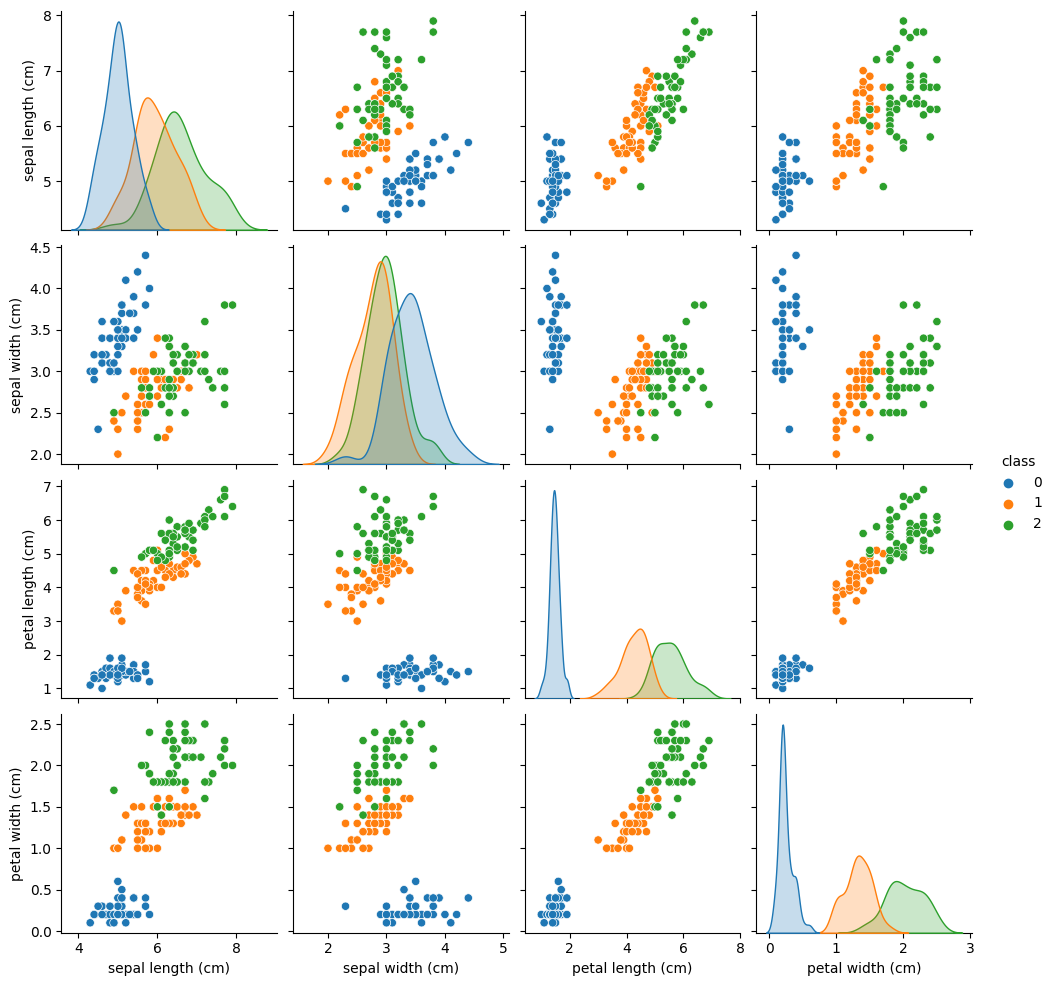

In [59]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

In [65]:
from sklearn.model_selection import train_test_split


random_seed = 51
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=random_seed
)

## SVC

In [77]:
# --- Specify service & backend ---
service = QiskitRuntimeService(channel='ibm_quantum')
qasm_backend = service.get_backend('ibmq_qasm_simulator') # a remote quantum simulator
aer_backend = Aer.get_backend('aer_simulator') # a local quantum simulator

### Kernel

In [81]:
# define your feature map
num_features = features.shape[1]
print(num_features)

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement="linear")

4


In [82]:
#define the Kernel
sampler = AerSampler()
fidelity = ComputeUncompute(sampler)


kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

### classical SVC

In [84]:
from sklearn.svm import SVC

svc = SVC(kernel=kernel.evaluate)
svc.fit(train_features, train_labels)
score_callable_function = svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {score_callable_function}")

Callable kernel classification test score: 1.0


In [86]:
matrix_train = kernel.evaluate(x_vec=train_features)
matrix_test = kernel.evaluate(x_vec=test_features, y_vec=train_features)

svc = SVC(kernel="precomputed")
svc.fit(matrix_train, train_labels)
score_precomputed_kernel = svc.score(matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


### quantum SVC

In [87]:
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


In [89]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       1.00
SVC using precomputed kernel matrix     |       1.00
QSVC                                    |       1.00


## Using code from hint

In [90]:
# visualize the kernel matrix 

K_train = qsvc.quantum_kernel.evaluate(x_vec=train_features)

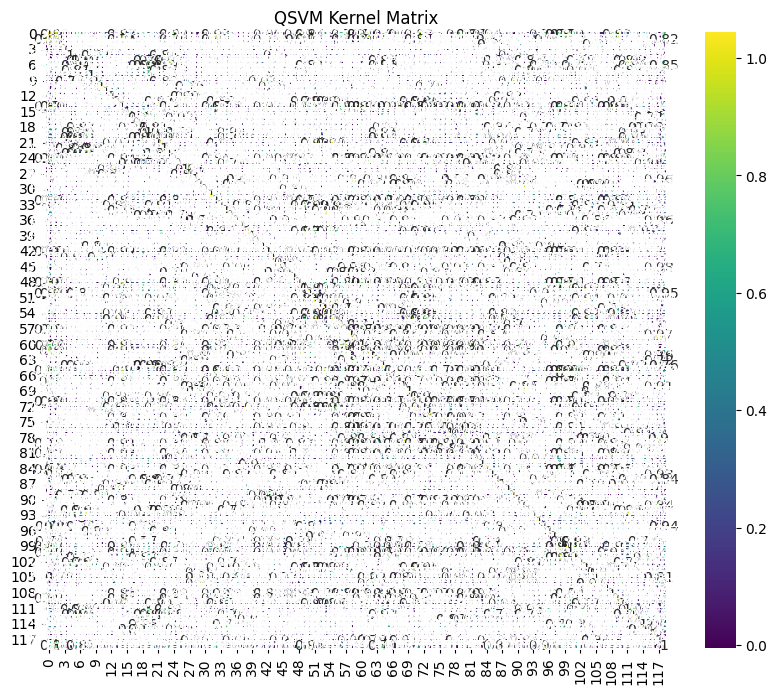

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the kernel matrix
plt.figure(figsize=(10, 8))
sns.heatmap(K_train, annot=True, cmap='viridis')
plt.title("QSVM Kernel Matrix")
plt.show()

In [93]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
predicted_labels = qsvc.predict(test_features)

# Calculate the accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 1.0
